# scoring using Convolutional Neural Network (CNN)

## Import The Required Libraries

In [15]:
# basics
import sys
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
import cv2
import pickle 
import glob
import shutil
# Keras Libraries
import keras
import tensorflow as tf
from keras import backend as K
from keras import metrics
from tensorflow.keras.utils import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.utils import  load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import AUC
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import keras.backend
import os
import random
import time
import datetime
from tensorflow.python.framework import ops
import inspect
import gc

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## utility functions

In [16]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today() 

In [17]:
# reset tensorflow graph tp free up memory and resource allocation 
def reset_graph(model=None):
    if model:
        try:
            del model
        except:
            return False
    
   
    ops.reset_default_graph()
    K.clear_session()
    
    gc.collect()
    
    return True


# reset callbacks 
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint = None
    reduce_lr = None
    early_stopping = None
    tensorboard = None

In [18]:
def create_directory(directory_path, remove=False):
    if remove and os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
            os.mkdir(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    else:
        try:
            os.mkdir(directory_path)
        except:
            print("Could not create directory: ", directory_path)
            return False
        
    return True

# Removes directory, if directory exists 
def remove_directory(directory_path):
    if os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
        
    return True

def clear_directory(directory_path):
    dirs_files = os.listdir(directory_path)
    
    for item in dirs_files:
#         item_path = os.path.join(directory_path, item)
        item_path = directory_path+ item
        
        try:
            if os.path.isfile(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path): 
                shutil.rmtree(item_path)
        except Exception as e:
            print(e)
            
    return True


def remove_empty_folders(path, removeRoot=True):
    if not os.path.isdir(path):
        return
    
    # remove empty subfolders
    files = os.listdir(path)
    
    if len(files):
        for f in files:
            fullpath = os.path.join(path, f)
            
            if os.path.isdir(fullpath):
                remove_empty_folders(fullpath)

    # if folder empty, delete it
    files = os.listdir(path)
    
    if len(files) == 0 and removeRoot:
        print("Removing empty folder:", path)
        os.rmdir(path)
        
        
def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

In [19]:
def create_charts(cnn, cnn_model):
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[3]
    val_auc_name = list(cnn_model.history.keys())[1]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Normal', 'Pneumonia']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout();
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

## code


In [20]:


input_directory = "/content/gdrive/MyDrive/Dataset/data1/"
output_directory = "/content/gdrive/MyDrive/Dataset/output/"

train_path = input_directory + r"train"
val_path = input_directory + r"valid"
test_path = input_directory + r"test"

figure_directory = "output/figures" 
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

main_model_dir = output_directory + r"models/"
main_log_dir = output_directory + r"logs/"


clear_directory(main_log_dir)
remove_empty_folders(main_model_dir, False)


model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)

model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"


Removing empty folder: /content/gdrive/MyDrive/Dataset/output/models/2023-02-04 08-34-08


In [21]:
reset_graph()
reset_callbacks()

### preprosessing

In [22]:
# Set a seed value
seed_value= 42

os.environ['PYTHONHASHSEED']=str(seed_value)


random.seed(seed_value)

np.random.seed(seed_value)

tf.random.set_seed(seed_value)


#6 Configure a new global `tensorflow` session

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [23]:
batch_size = 4
epochs=100
hyper_channels = 6

#imagesize=(688, 880,6)

### Loading dataset

In [24]:
path ="/content/gdrive/MyDrive/Dataset/data1"

train_score_0=glob.glob("/content/gdrive/MyDrive/Dataset/data1/train/score0"+'**/*.npy',recursive=True)
train_score_1=glob.glob("/content/gdrive/MyDrive/Dataset/data1/train/score1"+'**/*.npy',recursive=True)
train_score_2=glob.glob("/content/gdrive/MyDrive/Dataset/data1/train/score2"+'**/*.npy',recursive=True)
train_score_3=glob.glob("/content/gdrive/MyDrive/Dataset/data1/train/score3"+'**/*.npy',recursive=True)

valid_score_0=glob.glob("/content/gdrive/MyDrive/Dataset/data1/valid/score0"+'**/*.npy',recursive=True)
valid_score_1=glob.glob("/content/gdrive/MyDrive/Dataset/data1/valid/score1"+'**/*.npy',recursive=True)
valid_score_2=glob.glob("/content/gdrive/MyDrive/Dataset/data1/valid/score2"+'**/*.npy',recursive=True)
valid_score_3=glob.glob("/content/gdrive/MyDrive/Dataset/data1/valid/score3"+'**/*.npy',recursive=True)

test_score_0=glob.glob("/content/gdrive/MyDrive/Dataset/data1/test/score0"+'**/*.npy',recursive=True)
test_score_1=glob.glob("/content/gdrive/MyDrive/Dataset/data1/test/score1"+'**/*.npy',recursive=True)
test_score_2=glob.glob("/content/gdrive/MyDrive/Dataset/data1/test/score2"+'**/*.npy',recursive=True)
test_score_3=glob.glob("/content/gdrive/MyDrive/Dataset/data1/test/score3"+'**/*.npy',recursive=True)

In [25]:
X_train=[]
Y_train=[]

X_valid=[]
Y_valid=[]

X_test=[]
Y_test=[]

for i in train_score_0:
  X_train.append(np.load(i))
  Y_train.append([0,0,0,1])

for i in train_score_1:
  X_train.append(np.load(i))
  Y_train.append([0,0,1,0])

for i in train_score_2:
  X_train.append(np.load(i))
  Y_train.append([0,1,0,0])

for i in train_score_3:
  X_train.append(np.load(i))
  Y_train.append([1,0,0,0])


for i in valid_score_0:
  X_valid.append(np.load(i))
  Y_valid.append([0,0,0,1])

for i in valid_score_1:
  X_valid.append(np.load(i))
  Y_valid.append([0,0,1,0])

for i in valid_score_2:
  X_valid.append(np.load(i))
  Y_valid.append([0,1,0,0])

for i in valid_score_3:
  X_valid.append(np.load(i))
  Y_valid.append([1,0,0,0])





for i in test_score_0:
  X_test.append(np.load(i))
  Y_test.append([0,0,0,1])

for i in test_score_1:
  X_test.append(np.load(i))
  Y_test.append([0,0,1,0])

for i in test_score_2:
  X_test.append(np.load(i))
  Y_test.append([0,1,0,0])

for i in test_score_3:
  X_test.append(np.load(i))
  Y_test.append([1,0,0,0])


In [26]:
print(np.array(X_valid,dtype=np.uint8).shape)
print(np.array(Y_train,dtype=np.uint8).shape)

(69, 688, 880, 6)
(151, 4)


In [27]:
X_train=np.array(X_train)
X_valid=np.array(X_valid)
Y_valid=np.array(Y_valid)
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)
X_test=np.array(X_test)

<ipython-input-27-b444df03c475>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test=np.array(X_test)


In [29]:
train_generator = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

train_generator = train_generator.repeat().batch(batch_size)

val_generator = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))
 
val_generator = val_generator.batch(batch_size)

'''test_generator = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

test_generator = test_generator.repeat().batch(batch_size)'''


'test_generator = tf.data.Dataset.from_tensor_slices((X_test, Y_test))\n\ntest_generator = test_generator.repeat().batch(batch_size)'

(688, 880, 6)
this image label is  [0 0 0 1]


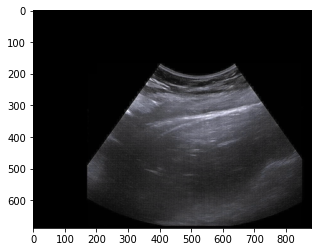

In [30]:
plt.imshow(X_train[0][:,:,:3])
print(X_train[5].shape)
print('this image label is ',Y_train[0])

## Model

In [31]:
STEP_SIZE_TRAIN = len(X_train)//batch_size
STEP_SIZE_VALID = len(X_valid)//batch_size

cnn = tf.keras.Sequential()
cnn.add(tf.keras.layers.InputLayer(input_shape=(688, 880,6)))
#here


cnn.add(Conv2D(32, (5, 5), activation='relu', padding="same"))
cnn.add(Conv2D(32, (5,5), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size=(5, 5)))
   
cnn.add(Conv2D(16, (5, 5), activation='relu', padding="same"))


cnn.add(MaxPooling2D(pool_size=(3, 3)))

cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu'))
#cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu'))


cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu'))
tf.keras.layers.BatchNormalization(renorm=True),



cnn.add(Dense(16, activation='relu'))

cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(activation='relu', units=1024))
cnn.add(tf.keras.layers.Dense(activation='relu', units=512))

cnn.add(Dropout(0.2, seed=seed_value))

cnn.add(tf.keras.layers.Dense(activation='softmax', units=4))
#here
'''cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

cnn.add(tf.keras.layers.Flatten())
cnn.add(Dropout(0.4))
cnn.add(tf.keras.layers.Dense(activation='relu', units=128))
cnn.add(tf.keras.layers.Dense(activation='softmax', units=4))'''

cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=.00001),loss='categorical_crossentropy',metrics=['accuracy'])


In [32]:
cnn.summary()

early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,verbose=1,
                                          restore_best_weights=True)
checkpoint=checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/gdrive/MyDrive/Dataset/output/checkpoints/my_model_npy_{epoch}.h5",
   save_best_only=True,
    verbose=1
)

callbacks=[early,checkpoint]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 688, 880, 32)      4832      
                                                                 
 conv2d_1 (Conv2D)           (None, 688, 880, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 137, 176, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 137, 176, 16)      12816     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 58, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 58, 16)        2

In [33]:
history = cnn.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    batch_size=batch_size,
                    callbacks=[early])

Epoch 1/50
37/37 [==============================] - 703s 19s/step - loss: 6.1152 - accuracy: 0.3378 - val_loss: 4.3523 - val_accuracy: 0.4706
Epoch 2/50
37/37 [==============================] - 699s 19s/step - loss: 4.4330 - accuracy: 0.0878 - val_loss: 1.9543 - val_accuracy: 0.4118
Epoch 3/50
37/37 [==============================] - 691s 19s/step - loss: 1.8255 - accuracy: 0.1824 - val_loss: 1.4646 - val_accuracy: 0.4118
Epoch 4/50
37/37 [==============================] - 689s 19s/step - loss: 1.4915 - accuracy: 0.2432 - val_loss: 1.4522 - val_accuracy: 0.4118
Epoch 5/50
37/37 [==============================] - 691s 19s/step - loss: 1.2263 - accuracy: 0.3851 - val_loss: 1.4854 - val_accuracy: 0.4118
Epoch 6/50
37/37 [==============================] - 691s 19s/step - loss: 1.2351 - accuracy: 0.4527 - val_loss: 1.4874 - val_accuracy: 0.4265
Epoch 7/50
37/37 [==============================] - 691s 19s/step - loss: 1.1059 - accuracy: 0.4932 - val_loss: 1.4818 - val_accuracy: 0.4118
Epoch 

In [34]:
cnn.save("/content/gdrive/MyDrive/Dataset/output/models/Modelnpy.h5")

In [38]:
accuracy_score = cnn.evaluate(val_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
 
print("Loss: ",accuracy_score[0])
Y_pred = cnn.predict(val_generator, steps = len(val_generator))
predictions = np.argmax(Y_pred, axis=1)


18/18 [==============================] - 65s 4s/step - loss: 1.4584 - accuracy: 0.4058
[1.4583656787872314, 0.4057970941066742]
Accuracy: 40.5797%
Loss:  1.4583656787872314
18/18 [==============================] - 65s 4s/step
